# Training 1d model

## Contents
* [Train process](#Train-process)
* [Data prepocessing](#Data-prepocessing)
* [Training model](#Training-model)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Predictions](#Predictions)
    * [Best predictions](#Best-predictions)
    * [Worst predictions](#Worst-predictions)
* [Operating time](#Operating-time)
* [Summary](#Summary)

## Train process
We train our model using stochastic gradient descent. On each iteration we
* load mini-batch data
* update the weights 

Algorith of weights update (optimizer) is the Nesterov momentum with hyperparameters:
* ```learning_rate``` = 0.01
* ```mu``` = 0.5

The choice of optimizer hyperparameters is motivated by the [research](./parameters_estimation_1d_model.ipynb), as for they show the best convergence.

Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 64

* ```n_epochs``` = 10.

In [1]:
import os
import sys
import time

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join(".."))
from radial.batchflow import Dataset, FilesIndex, Pipeline, B, V
from radial.batchflow.models.tf import TFModel

from radial.core import RadialBatch
from radial.core.radial_batch_tools import draw_predictions, \
                                           calculate_results

plt.style.use('ggplot')
%matplotlib inline

In [2]:
%env CUDA_VISIBLE_DEVICES=1, 5, 6, 7

env: CUDA_VISIBLE_DEVICES=1, 5, 6, 7


## Data preprocessing

Firstly you need to load the data.

In [3]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)

After you should to determine the preprocessing pipeline.

In [4]:
GRID_SIZE = 200

prep_pipeline = (Pipeline()
                .init_variable('loss_history_dict', init_on_each_run=0)
                .hard_negative_sampling(statistics_name='loss_history_dict', fraction=0.33)
                .load(fmt='npz')
                .drop_negative(src=['time', 'derivative', 'target'])
                .to_log10(src=['time', 'derivative', 'target'],
                          dst=['log_time', 'log_derivative', 'log_target'])
                .normalize(src=['log_time', 'log_derivative'], 
                           dst=['log_norm_time', 'log_norm_derivative'],\
                           dst_range=[None, 'derivative_range'])
                .normalize(src='log_target', dst='log_norm_target',
                           src_range='derivative_range')
                .expand_dims(src='log_norm_target')
                .make_grid_data(src=['log_norm_time', 'log_norm_derivative'],
                                dst=['log_norm_time_grid', 'log_norm_derivative_grid'],
                                grid_size=GRID_SIZE)
                .make_array(src='log_norm_derivative_grid', dst='derivative_grid')
           )

Next step is creation of config.

In [5]:
model_config = {
    'inputs': dict(signals=dict(shape=(GRID_SIZE, 1)),
                   labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cna cna cna', filters=[64, 128, 256],
                 strides=2, kernel_size=3),    
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'signals',
    'loss': 'mse',
    'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5})}

## Training model

Now you finally can creae a train and test pipelines.

In [6]:
train_pipeline = (prep_pipeline 
                 .init_variable('loss')
                 .init_variable('mean_loss_history', init_on_each_run=list)
                 .init_variable('loss_history', init_on_each_run=0)
                 .init_model('dynamic', TFModel, 'model', config=model_config)
                 .train_model('model', fetches=['loss',
                                                'TFModel/mean_squared_error/SquaredDifference:0'],
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('log_norm_target')},
                           save_to=[V('loss'), V('loss_history')], mode='w')
                 .update_variable('mean_loss_history', V('loss'), mode='a')
                 .update_loss_history_dict() << ds_train
                 )

In [7]:
test_pipeline = (prep_pipeline + 
                 Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .import_model('model', train_pipeline)
                  .predict_model('model', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('log_norm_target')}, 
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .clip_values(src='predictions', dst='predictions')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('targets', B('log_target'), mode='e')
                  .update_variable('predictions', B('denorm_predictions'), mode='e')
                ) << ds_test

Execute training

In [8]:
train_pipeline.reset_iter()
test_pipeline.reset_iter()

In [9]:
BATCH_SIZE = 16

for i in tqdm(range(2000)):
    train_pipeline.next_batch(BATCH_SIZE, n_epochs=None, drop_last=True, shuffle=True)
    test_pipeline.next_batch(BATCH_SIZE, n_epochs=None, drop_last=True, shuffle=True)
print('done')

100%|██████████| 2000/2000 [06:14<00:00,  5.35it/s]

done


The loss function vs number of iterations:

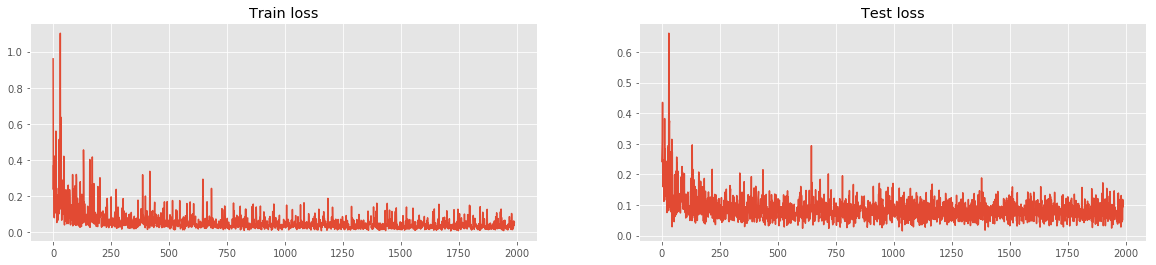

In [10]:
_, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_pipeline.get_variable('mean_loss_history')[10:])
ax[0].set_title("Train loss")
ax[1].plot(test_pipeline.get_variable('loss_history')[10:])
ax[1].set_title("Test loss")
plt.show()

## Inference

Prediction pipeline:

In [11]:
predict_template = prep_pipeline + (Pipeline()
                                    .init_variable('targets', init_on_each_run=list)
                                    .init_variable('predictions', init_on_each_run=list)
                                    .init_variable('ind', init_on_each_run=list)
                                    .import_model('model', train_pipeline)
                                    .predict_model('model', fetches='predictions',
                                                 feed_dict={'signals': B('derivative_grid')},
                                                 save_to=B('predictions'), mode='w')
                                    .clip_values(src='predictions', dst='predictions')
                                    .denormalize(src=['predictions', 'log_norm_target'],
                                                dst=['denorm_predictions', 'denorm_target'],
                                                src_range=['derivative_range', 'derivative_range'])
                                    .update_variable('ind', B('indices'), mode='e')
                                    .update_variable('predictions', B('denorm_predictions'), mode='e')
                                    .update_variable('targets', B('denorm_target'), mode='e') << ds_test
)

Execute prediction pipeline.

In [12]:
predict_pipeline = predict_template << ds_test
predict_pipeline.run(10, n_epochs=1, drop_last=True, bar=True)

 89%|████████▉ | 8/9 [00:00<00:00, 11.50it/s]


## Model evaluation

Quality metric, in this case, is percentage of items with absolute percentage error less than 30% on the test set. We call it `test_mape30`

Metric evaluation:

In [13]:
test_pipeline.reset_iter()
test_batch = test_pipeline.next_batch(len(ds_test))

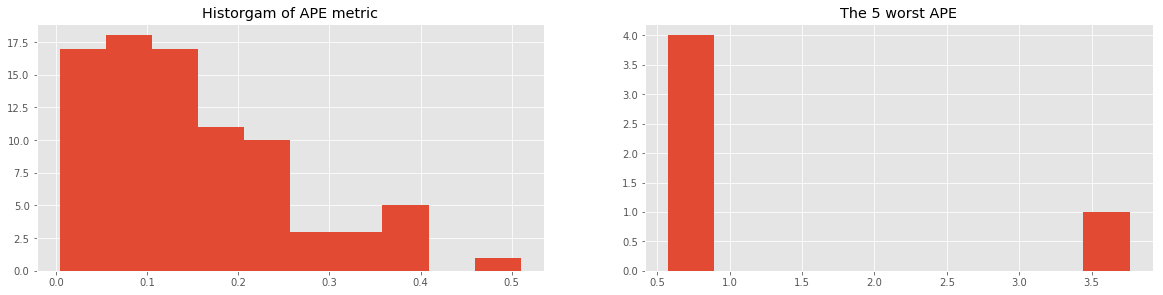

In [14]:
metrics = np.abs(test_batch.denorm_predictions.reshape(-1) - test_batch.log_target.reshape(-1)) / test_batch.log_target.reshape(-1)
metrics = metrics.astype(np.float32)

plt.figure(1, figsize=(20, 10))
plt.subplot(221)
plt.title('Historgam of APE metric')
plt.hist(np.sort(metrics)[:-5])
plt.subplot(222)
plt.title('The 5 worst APE')
plt.hist(np.sort(metrics)[-5:])
plt.show()

In [15]:
print('Average metrics is', np.mean(metrics < 0.3) * 100)

Average metrics is 91.11111111111111


## Predictions

### Best predictions
Now let's see an examples with the smallest error value.

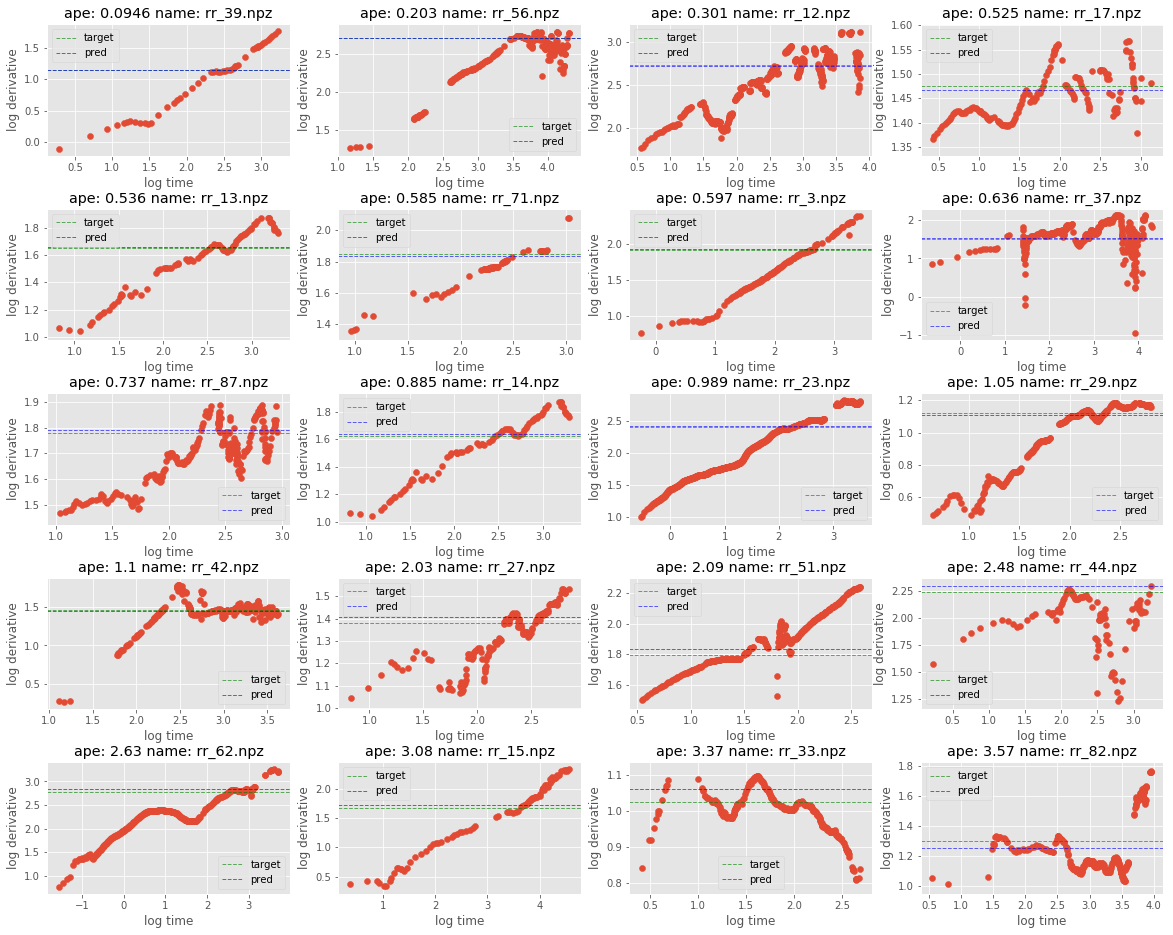

In [16]:
results, names = calculate_results(predict_pipeline)

draw_predictions(results, names[:20], path="./data_splited/test_isol/")

### Worst predictions
Let's proceed to the examples with the highest error value.

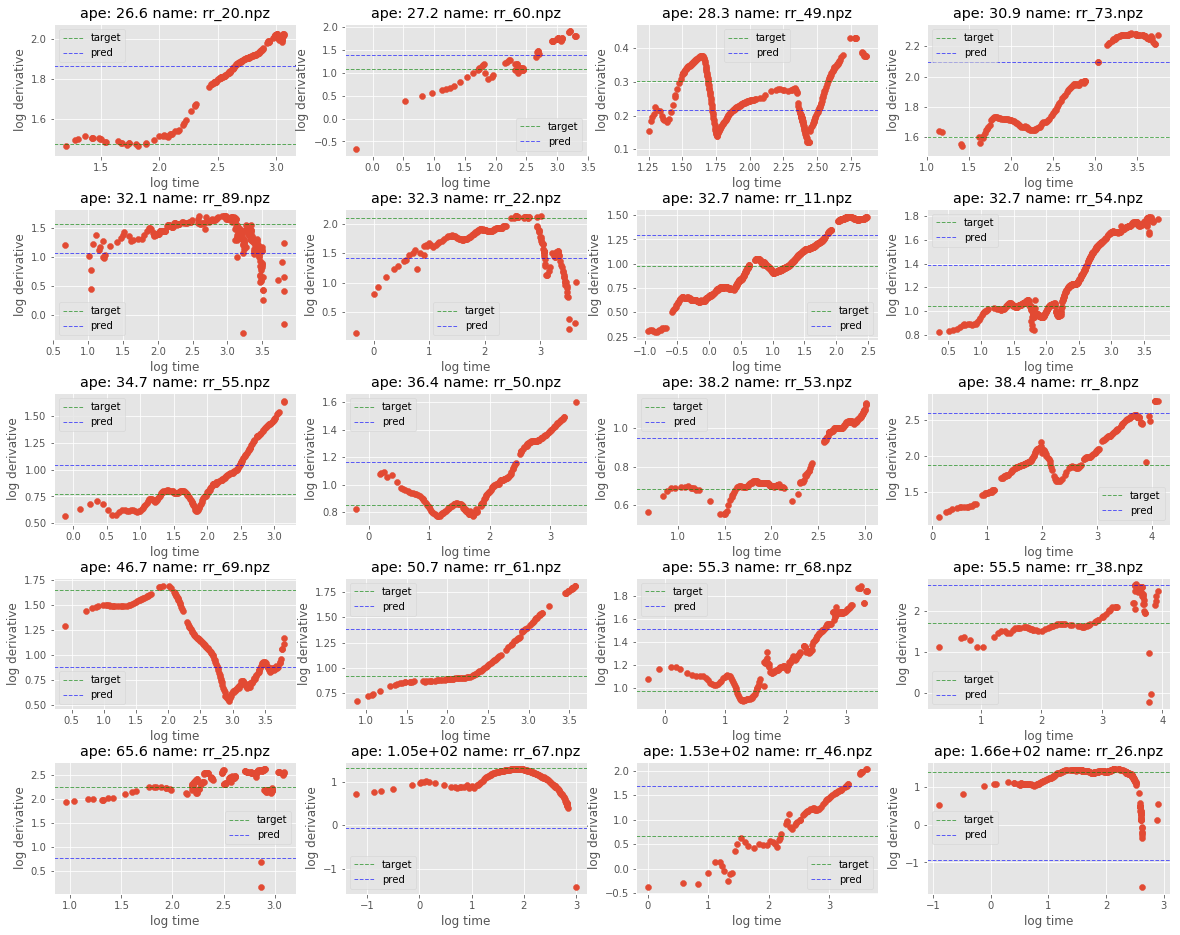

In [17]:
draw_predictions(results, names[-20:], path="./data_splited/test_isol/")

## Operating time

Device: GPU NVIDIA 1080.

One train step on batch size 16 takes 246 ms. Training time for 102 epochs is 393 s.

One item inference takes 39 ms, for batch size 16 - 48 ms.

In [18]:
start_time = time.clock()
train_pipeline.next_batch(16)
print(time.clock() - start_time)

0.2468250000001717


In [19]:
start_time = time.clock()
for i in range(2000):
    train_pipeline.next_batch(BATCH_SIZE, n_epochs=None, drop_last=True, shuffle=True)
print(time.clock() - start_time)

393.5337500000005


In [20]:
start_time = time.clock()
predict_pipeline.next_batch(1)
print(time.clock() - start_time)

0.038983999998890795


In [21]:
start_time = time.clock()
predict_pipeline.next_batch(16)
print(time.clock() - start_time)

0.04827300000033574


## Summary

The model predicts a position of the radial mode according to the pressure derivative vs time data. The mean model metrics corresponding to a percentage of items with absolute percentage error less than 30% is 91.91%